# Lab assignment №2: Gradient boosting and feature importance estimation

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

There are several great frameworks (listed below). However, we recommend to stick to `LightGBM` for this task.
* LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). It is one of the most popular frameworks these days that shows both great quality and performance.
* xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
* Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Parts 1 and 3 have the same weight equal to $1$. Part 2 has weight $0.5$.

### Part 1:
Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset:

* $\geq 90\%$ accuracy: 0.5 points for this part
* $\geq 92\%$ accuracy: 0.7 points for this part
* $\geq 94\%$ accuracy: 1 point for this part

In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

In [2]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [3]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [4]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [5]:
try: 
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/Lab2_boosting/unique_columns.txt -nc
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)

X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [6]:
pca = PCA(0.99)

In [7]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [8]:
X_train_pca.shape

(7352, 179)

In [9]:
X_test_pca.shape

(2947, 179)

Text(0, 0.5, 'Principal component 2')

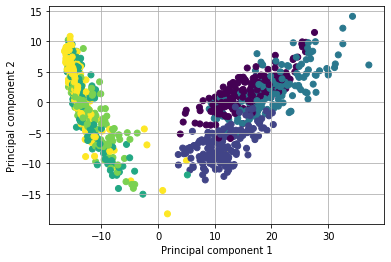

In [10]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

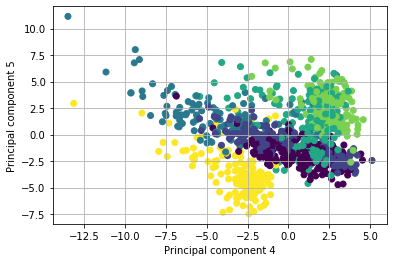

In [11]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

Please try at least several models of different structure.

Provide the following to describe your path:

* Plot describing the model accuracy/precision/recall w.r.t. model complexity.
* ROC-AUC plot for the 3 best models you aquired (for multiclass case you might refer to the `scikit-plot` library.
* Small report describing your experiments.

[DART](https://arxiv.org/abs/1505.01866) might be useful as well in your experiments. It is available in [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters.html), but seems [missing in CatBoost](https://github.com/catboost/catboost/issues/1006).

__Without the report and plots maximum score for this part of the lab is 0.3 of its full weight.__

In [245]:
from lightgbm import LGBMClassifier
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Выберем пределы для параметров `LGBMClassifier`. Далее для каждого набора будем запускать `LGBMClassifier` с каждым параметром из этого набора, а остальными дефолтными.

In [79]:
num_iterations_arange = np.arange(10, 500, 10) # like n_estimators
max_depth_arange = np.arange(3, 25)
min_data_in_leaf_arange = np.arange(1, 10)
learning_rate_arange = np.logspace(-3, 0.5, 50)
feature_fraction_arange = np.linspace(0.01, 1, 20) # something like max_features
bagging_fraction_arange = np.linspace(0.01, 1, 20) # bagging_freq != 0

In [226]:
accs = []

for n in tqdm_notebook(num_iterations_arange):
    clf = LGBMClassifier(n_estimators = n)
    clf.fit(X_train_pca, y_train)
    accs.append(accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_pca)))

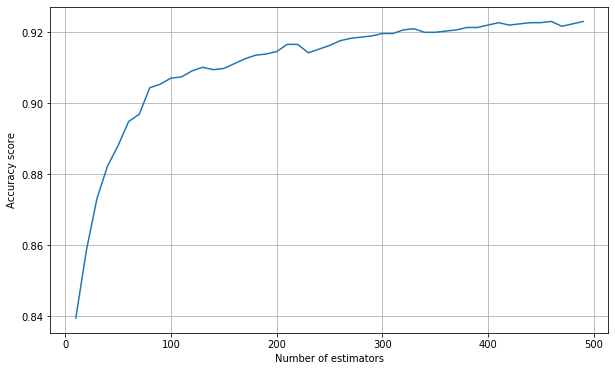

In [227]:
plt.figure(figsize=(10, 6))
plt.ylabel("Accuracy score")
plt.xlabel("Number of estimators")
plt.plot(num_iterations_arange, accs)
plt.grid()
plt.show()

Из графика можно заметить, что при $n\_estimators > 300$ точность модели растет сильно меньше, а время обучения, естественно, увеличивается. Поэтому лучше не брать большое количество шагов.

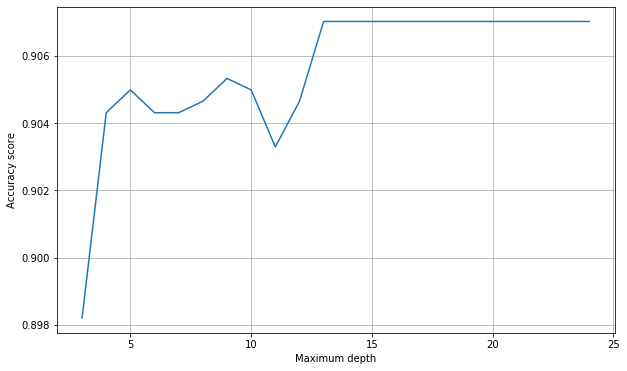

In [47]:
accs2 = []

for depth in tqdm_notebook(max_depth_arange):
    clf = LGBMClassifier(max_depth=depth)
    clf.fit(X_train_pca, y_train)
    accs2.append(accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_pca)))

plt.figure(figsize=(10, 6))
plt.ylabel("Accuracy score")
plt.xlabel("Maximum depth")
plt.plot(max_depth_arange, accs2)
plt.grid()
plt.show()

Скорее всего при $max\_depth \geq 13$ происходит переобучение модели. Из графика можно сказать, что параметр `max_depth` лучше выбирать в пределеах от 4 до 10. В зависимости от выбора этого параметра точность модели меняется максимум на $0.007$, значит, модель мало зависит от этого параметра.

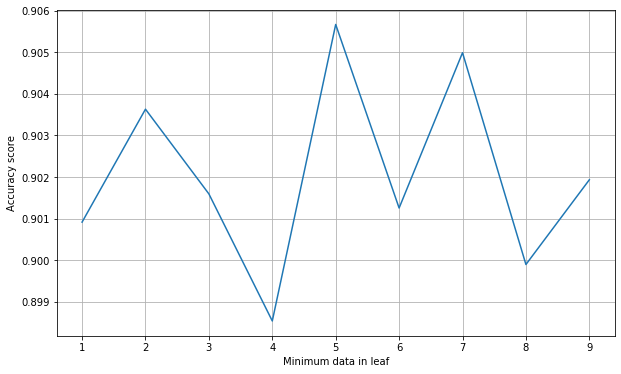

In [48]:
accs3 = []

for min_data in tqdm_notebook(min_data_in_leaf_arange):
    clf = LGBMClassifier(min_data_in_leaf=min_data)
    clf.fit(X_train_pca, y_train)
    accs3.append(accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_pca)))

plt.figure(figsize=(10, 6))
plt.ylabel("Accuracy score")
plt.xlabel("Minimum data in leaf")
plt.plot(min_data_in_leaf_arange, accs3)
plt.grid()
plt.show()

Из этого графика можно сделать вывод, что `min_data_in_leaf` необходимо подбирать отдельно после выбора остальных. Точность модели от выбора этого параметра меняется на $0.007$ максимум. Значит, модель несильно зависит от этого параметра в отличие от остальных.

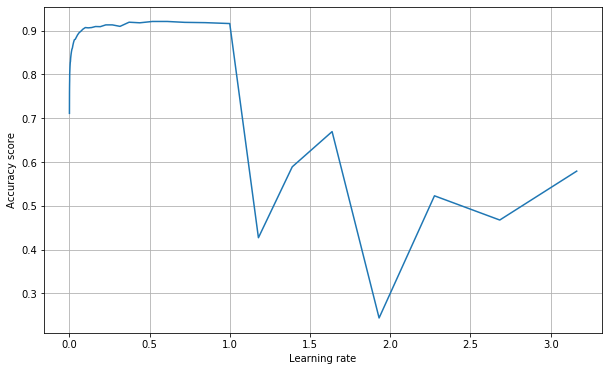

In [230]:
accs4 = []

for learn_rate in tqdm_notebook(learning_rate_arange):
    clf = LGBMClassifier(learning_rate=learn_rate)
    clf.fit(X_train_pca, y_train)
    accs4.append(accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_pca)))

plt.figure(figsize=(10, 6))
plt.ylabel("Accuracy score")
plt.xlabel("Learning rate")
plt.plot(learning_rate_arange, accs4)
plt.grid()
plt.show()

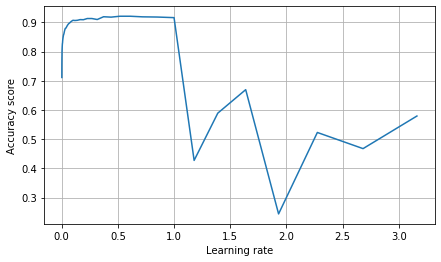

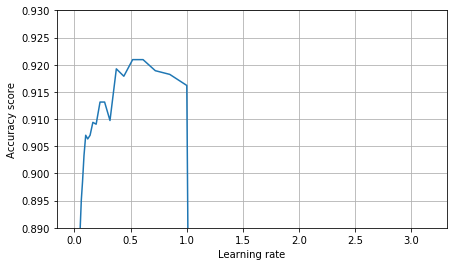

In [233]:
plt.figure(figsize=(7, 4))
plt.ylabel("Accuracy score")
plt.xlabel("Learning rate")
plt.plot(learning_rate_arange, accs4)
plt.grid()
plt.show()

plt.figure(figsize=(7, 4))
plt.ylabel("Accuracy score")
plt.xlabel("Learning rate")
plt.ylim(0.89, 0.93)
plt.plot(learning_rate_arange, accs4)
plt.grid()
plt.show()

Из первого графика видно, что $learning\_rate$ лучше всгео выбирать между $0.0$ и $1.0$. Из второго же графика видно, что точность выше всего при $learning\_rate \approx 0.5$. От этого параметра очень сильно зависит точность модели.

In [234]:
accs5 = []

for ff in tqdm_notebook(feature_fraction_arange):
    clf = LGBMClassifier(feature_fraction=ff)
    clf.fit(X_train_pca, y_train)
    accs5.append(accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_pca)))

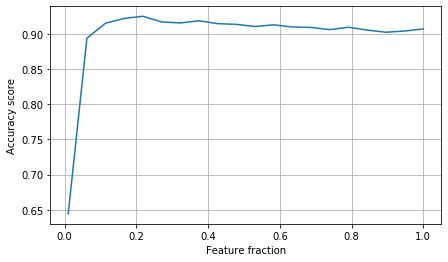

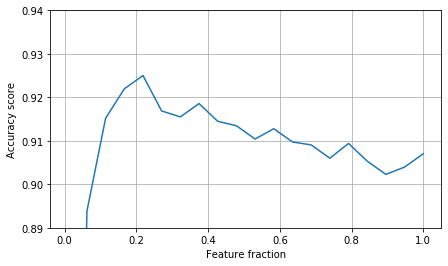

In [235]:
plt.figure(figsize=(7, 4))
plt.ylabel("Accuracy score")
plt.xlabel("Feature fraction")
plt.plot(feature_fraction_arange, accs5)
plt.grid()
plt.show()

plt.figure(figsize=(7, 4))
plt.ylabel("Accuracy score")
plt.xlabel("Feature fraction")
plt.ylim(0.89, 0.94)
plt.plot(feature_fraction_arange, accs5)
plt.grid()
plt.show()

Из графиков можно сказать, что точность модели меняется в пределах $0.90-0.92$ при $feature\_fraction \ge 0.1$. Лучше всего выбирать его около $0.2$

In [236]:
accs6 = []

for bf in tqdm_notebook(bagging_fraction_arange):
    clf = LGBMClassifier(bagging_fraction=bf, bagging_freq=1)
    clf.fit(X_train_pca, y_train)
    accs6.append(accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_pca)))

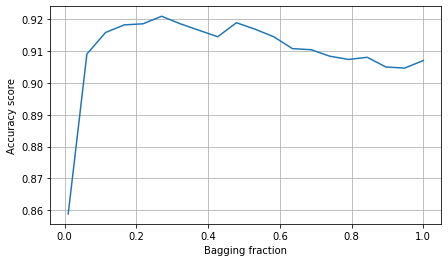

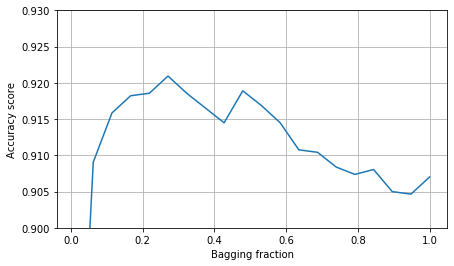

In [243]:
plt.figure(figsize=(7, 4))
plt.ylabel("Accuracy score")
plt.xlabel("Bagging fraction")
plt.plot(feature_fraction_arange, accs6)
plt.grid()
plt.show()

plt.figure(figsize=(7, 4))
plt.ylabel("Accuracy score")
plt.xlabel("Bagging fraction")
plt.ylim(0.90, 0.93)
plt.plot(feature_fraction_arange, accs6)
plt.grid()
plt.show()

Из графиков можно сказать, что точность модели меняется в пределах  $0.90−0.92$  при  $feature\_freation \ge 0.1$. Лучше всего выбирать его около $0.2$.

### Первая модель
По построенным выше графикам выберем оптимальные параметры и рассмотрим эту модель.

In [255]:
first_model = LGBMClassifier(
    n_estimators=420,
    min_data_in_leaf=5,
    max_depth=13,
    learning_rate=0.5,
    feature_fraction=0.2,
    bagging_fraction=0.27,
    random_state=23
)
first_model.fit(X_train_unique, y_train)
accuracy_score(y_true=y_test, y_pred=first_model.predict(X_test_unique))

0.9440108585001696

### Вторая модель
Вторую модель построим по параметрам, подобранным с помощью random search около оптимальных значений, рассмотренных выше. 

In [249]:
from sklearn.model_selection import RandomizedSearchCV

In [250]:
params = {
    "n_estimators": np.arange(300, 500, 10),
    "max_depth": np.arange(1, 14),
    "min_data_in_leaf": np.arange(1, 5),
    "learning_rate": np.asarray([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]),
    "feature_fraction": np.linspace(0.1, 1.0, 10),
    "bagging_fraction": np.linspace(0.1, 1.0, 10),
    "lambda_l1": np.asarray([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]),
    "lambda_l2": np.asarray([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0])    
}

In [251]:
random_search = RandomizedSearchCV(
    estimator=LGBMClassifier(bagging_freq=1),
    param_distributions=params,
    n_iter=20,
    scoring="accuracy",
    cv=5,
    verbose=10
)

In [252]:
random_search.fit(X_train_unique, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_estimators=410, min_data_in_leaf=2, max_depth=4, learning_rate=1.0, lambda_l2=1.0, lambda_l1=1.0, feature_fraction=0.2, bagging_fraction=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=410, min_data_in_leaf=2, max_depth=4, learning_rate=1.0, lambda_l2=1.0, lambda_l1=1.0, feature_fraction=0.2, bagging_fraction=0.6, score=0.917, total=   3.2s
[CV] n_estimators=410, min_data_in_leaf=2, max_depth=4, learning_rate=1.0, lambda_l2=1.0, lambda_l1=1.0, feature_fraction=0.2, bagging_fraction=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV]  n_estimators=410, min_data_in_leaf=2, max_depth=4, learning_rate=1.0, lambda_l2=1.0, lambda_l1=1.0, feature_fraction=0.2, bagging_fraction=0.6, score=0.902, total=   3.3s
[CV] n_estimators=410, min_data_in_leaf=2, max_depth=4, learning_rate=1.0, lambda_l2=1.0, lambda_l1=1.0, feature_fraction=0.2, bagging_fraction=0.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV]  n_estimators=410, min_data_in_leaf=2, max_depth=4, learning_rate=1.0, lambda_l2=1.0, lambda_l1=1.0, feature_fraction=0.2, bagging_fraction=0.6, score=0.913, total=   3.1s
[CV] n_estimators=410, min_data_in_leaf=2, max_depth=4, learning_rate=1.0, lambda_l2=1.0, lambda_l1=1.0, feature_fraction=0.2, bagging_fraction=0.6 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.6s remaining:    0.0s


[CV]  n_estimators=410, min_data_in_leaf=2, max_depth=4, learning_rate=1.0, lambda_l2=1.0, lambda_l1=1.0, feature_fraction=0.2, bagging_fraction=0.6, score=0.943, total=   3.7s
[CV] n_estimators=410, min_data_in_leaf=2, max_depth=4, learning_rate=1.0, lambda_l2=1.0, lambda_l1=1.0, feature_fraction=0.2, bagging_fraction=0.6 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.3s remaining:    0.0s


[CV]  n_estimators=410, min_data_in_leaf=2, max_depth=4, learning_rate=1.0, lambda_l2=1.0, lambda_l1=1.0, feature_fraction=0.2, bagging_fraction=0.6, score=0.960, total=   3.1s
[CV] n_estimators=420, min_data_in_leaf=4, max_depth=3, learning_rate=0.2, lambda_l2=1.0, lambda_l1=0.5, feature_fraction=0.5, bagging_fraction=0.6 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.4s remaining:    0.0s


[CV]  n_estimators=420, min_data_in_leaf=4, max_depth=3, learning_rate=0.2, lambda_l2=1.0, lambda_l1=0.5, feature_fraction=0.5, bagging_fraction=0.6, score=0.925, total=   9.7s
[CV] n_estimators=420, min_data_in_leaf=4, max_depth=3, learning_rate=0.2, lambda_l2=1.0, lambda_l1=0.5, feature_fraction=0.5, bagging_fraction=0.6 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   26.1s remaining:    0.0s


[CV]  n_estimators=420, min_data_in_leaf=4, max_depth=3, learning_rate=0.2, lambda_l2=1.0, lambda_l1=0.5, feature_fraction=0.5, bagging_fraction=0.6, score=0.917, total=   8.3s
[CV] n_estimators=420, min_data_in_leaf=4, max_depth=3, learning_rate=0.2, lambda_l2=1.0, lambda_l1=0.5, feature_fraction=0.5, bagging_fraction=0.6 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   34.4s remaining:    0.0s


[CV]  n_estimators=420, min_data_in_leaf=4, max_depth=3, learning_rate=0.2, lambda_l2=1.0, lambda_l1=0.5, feature_fraction=0.5, bagging_fraction=0.6, score=0.914, total=   9.2s
[CV] n_estimators=420, min_data_in_leaf=4, max_depth=3, learning_rate=0.2, lambda_l2=1.0, lambda_l1=0.5, feature_fraction=0.5, bagging_fraction=0.6 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   43.6s remaining:    0.0s


[CV]  n_estimators=420, min_data_in_leaf=4, max_depth=3, learning_rate=0.2, lambda_l2=1.0, lambda_l1=0.5, feature_fraction=0.5, bagging_fraction=0.6, score=0.956, total=   9.1s
[CV] n_estimators=420, min_data_in_leaf=4, max_depth=3, learning_rate=0.2, lambda_l2=1.0, lambda_l1=0.5, feature_fraction=0.5, bagging_fraction=0.6 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   52.7s remaining:    0.0s


[CV]  n_estimators=420, min_data_in_leaf=4, max_depth=3, learning_rate=0.2, lambda_l2=1.0, lambda_l1=0.5, feature_fraction=0.5, bagging_fraction=0.6, score=0.961, total=   8.5s
[CV] n_estimators=340, min_data_in_leaf=1, max_depth=12, learning_rate=0.05, lambda_l2=0.005, lambda_l1=0.005, feature_fraction=0.5, bagging_fraction=0.2 
[CV]  n_estimators=340, min_data_in_leaf=1, max_depth=12, learning_rate=0.05, lambda_l2=0.005, lambda_l1=0.005, feature_fraction=0.5, bagging_fraction=0.2, score=0.923, total=  31.1s
[CV] n_estimators=340, min_data_in_leaf=1, max_depth=12, learning_rate=0.05, lambda_l2=0.005, lambda_l1=0.005, feature_fraction=0.5, bagging_fraction=0.2 
[CV]  n_estimators=340, min_data_in_leaf=1, max_depth=12, learning_rate=0.05, lambda_l2=0.005, lambda_l1=0.005, feature_fraction=0.5, bagging_fraction=0.2, score=0.910, total=  32.3s
[CV] n_estimators=340, min_data_in_leaf=1, max_depth=12, learning_rate=0.05, lambda_l2=0.005, lambda_l1=0.005, feature_fraction=0.5, bagging_fracti

[CV]  n_estimators=480, min_data_in_leaf=4, max_depth=12, learning_rate=0.01, lambda_l2=1.0, lambda_l1=0.2, feature_fraction=0.8, bagging_fraction=0.2, score=0.946, total=  37.7s
[CV] n_estimators=380, min_data_in_leaf=3, max_depth=2, learning_rate=0.005, lambda_l2=0.2, lambda_l1=0.001, feature_fraction=0.2, bagging_fraction=0.8 
[CV]  n_estimators=380, min_data_in_leaf=3, max_depth=2, learning_rate=0.005, lambda_l2=0.2, lambda_l1=0.001, feature_fraction=0.2, bagging_fraction=0.8, score=0.885, total=   5.1s
[CV] n_estimators=380, min_data_in_leaf=3, max_depth=2, learning_rate=0.005, lambda_l2=0.2, lambda_l1=0.001, feature_fraction=0.2, bagging_fraction=0.8 
[CV]  n_estimators=380, min_data_in_leaf=3, max_depth=2, learning_rate=0.005, lambda_l2=0.2, lambda_l1=0.001, feature_fraction=0.2, bagging_fraction=0.8, score=0.900, total=   5.1s
[CV] n_estimators=380, min_data_in_leaf=3, max_depth=2, learning_rate=0.005, lambda_l2=0.2, lambda_l1=0.001, feature_fraction=0.2, bagging_fraction=0.8 


[CV]  n_estimators=430, min_data_in_leaf=4, max_depth=2, learning_rate=0.05, lambda_l2=0.005, lambda_l1=1.0, feature_fraction=0.30000000000000004, bagging_fraction=0.4, score=0.954, total=   5.5s
[CV] n_estimators=430, min_data_in_leaf=4, max_depth=2, learning_rate=0.05, lambda_l2=0.005, lambda_l1=1.0, feature_fraction=0.30000000000000004, bagging_fraction=0.4 
[CV]  n_estimators=430, min_data_in_leaf=4, max_depth=2, learning_rate=0.05, lambda_l2=0.005, lambda_l1=1.0, feature_fraction=0.30000000000000004, bagging_fraction=0.4, score=0.961, total=   5.6s
[CV] n_estimators=310, min_data_in_leaf=2, max_depth=3, learning_rate=0.3, lambda_l2=0.1, lambda_l1=0.5, feature_fraction=0.7000000000000001, bagging_fraction=0.4 
[CV]  n_estimators=310, min_data_in_leaf=2, max_depth=3, learning_rate=0.3, lambda_l2=0.1, lambda_l1=0.5, feature_fraction=0.7000000000000001, bagging_fraction=0.4, score=0.921, total=   6.0s
[CV] n_estimators=310, min_data_in_leaf=2, max_depth=3, learning_rate=0.3, lambda_l2

[CV]  n_estimators=450, min_data_in_leaf=4, max_depth=12, learning_rate=0.001, lambda_l2=0.005, lambda_l1=0.5, feature_fraction=0.6, bagging_fraction=0.6, score=0.856, total=  49.7s
[CV] n_estimators=450, min_data_in_leaf=4, max_depth=12, learning_rate=0.001, lambda_l2=0.005, lambda_l1=0.5, feature_fraction=0.6, bagging_fraction=0.6 
[CV]  n_estimators=450, min_data_in_leaf=4, max_depth=12, learning_rate=0.001, lambda_l2=0.005, lambda_l1=0.5, feature_fraction=0.6, bagging_fraction=0.6, score=0.899, total=  50.9s
[CV] n_estimators=450, min_data_in_leaf=4, max_depth=12, learning_rate=0.001, lambda_l2=0.005, lambda_l1=0.5, feature_fraction=0.6, bagging_fraction=0.6 
[CV]  n_estimators=450, min_data_in_leaf=4, max_depth=12, learning_rate=0.001, lambda_l2=0.005, lambda_l1=0.5, feature_fraction=0.6, bagging_fraction=0.6, score=0.938, total=  49.8s
[CV] n_estimators=440, min_data_in_leaf=4, max_depth=9, learning_rate=0.3, lambda_l2=0.005, lambda_l1=0.005, feature_fraction=0.6, bagging_fractio

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 25.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LGBMClassifier(bagging_freq=1,
                                            boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, re...
                                        'learning_rate': array([0.001, 0.005, 0.01 , 0.05 , 0.1  , 0.2  , 0.3  , 0.5  , 1.   ]

In [253]:
random_search.best_params_

{'n_estimators': 420,
 'min_data_in_leaf': 4,
 'max_depth': 3,
 'learning_rate': 0.2,
 'lambda_l2': 1.0,
 'lambda_l1': 0.5,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.6}

In [254]:
random_model = LGBMClassifier(
    n_estimators=420,
    min_data_in_leaf=4,
    max_depth=3,
    learning_rate=0.2,
    lambda_l2=1.0,
    lambda_l1=0.5,
    feature_fraction=0.5,
    bagging_fraction=0.6
)
random_model.fit(X_train_unique, y_train)
accuracy_score(y_true=y_test, y_pred=random_model.predict(X_test_unique))

0.9504580929759077

### Третья модель
Сделаем последовательный grid search по группам признаков. Изначально выберем значения параметров как у самой первой модели и постепенно будем подбирать. Это сделано потому, что полноценный grid search выполняется крайне долго.

In [256]:
from sklearn.model_selection import GridSearchCV

In [306]:
gs_params_1 = {
    "n_estimators": np.arange(300, 500, 10)
}

gs_clf1 = GridSearchCV(
    estimator=LGBMClassifier(
        max_depth=13,
        min_data_in_leaf=5,
        learning_rate=0.05,
        feature_fraction=0.2,
        bagging_fraction=0.27,
        bagging_freq=1
        ),
    param_grid=gs_params_1,
    scoring="accuracy",
    cv=5,
    verbose=10
)

In [307]:
gs_clf1.fit(X_train_unique, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_estimators=300 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... n_estimators=300, score=0.925, total=  23.3s
[CV] n_estimators=300 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.3s remaining:    0.0s


[CV] .................... n_estimators=300, score=0.913, total=  22.9s
[CV] n_estimators=300 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.2s remaining:    0.0s


[CV] .................... n_estimators=300, score=0.929, total=  22.7s
[CV] n_estimators=300 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[CV] .................... n_estimators=300, score=0.938, total=  25.6s
[CV] n_estimators=300 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s


[CV] .................... n_estimators=300, score=0.965, total=  23.0s
[CV] n_estimators=310 ................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s


[CV] .................... n_estimators=310, score=0.924, total=  22.2s
[CV] n_estimators=310 ................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.3min remaining:    0.0s


[CV] .................... n_estimators=310, score=0.913, total=  21.2s
[CV] n_estimators=310 ................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.7min remaining:    0.0s


[CV] .................... n_estimators=310, score=0.931, total=  22.8s
[CV] n_estimators=310 ................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.1min remaining:    0.0s


[CV] .................... n_estimators=310, score=0.937, total=  25.9s
[CV] n_estimators=310 ................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.5min remaining:    0.0s


[CV] .................... n_estimators=310, score=0.966, total=  22.6s
[CV] n_estimators=320 ................................................
[CV] .................... n_estimators=320, score=0.926, total=  24.2s
[CV] n_estimators=320 ................................................
[CV] .................... n_estimators=320, score=0.914, total=  24.8s
[CV] n_estimators=320 ................................................
[CV] .................... n_estimators=320, score=0.931, total=  25.7s
[CV] n_estimators=320 ................................................
[CV] .................... n_estimators=320, score=0.939, total=  26.8s
[CV] n_estimators=320 ................................................
[CV] .................... n_estimators=320, score=0.966, total=  24.8s
[CV] n_estimators=330 ................................................
[CV] .................... n_estimators=330, score=0.925, total=  25.5s
[CV] n_estimators=330 ................................................
[CV] .

[CV] .................... n_estimators=430, score=0.933, total=  24.5s
[CV] n_estimators=430 ................................................
[CV] .................... n_estimators=430, score=0.944, total=  24.7s
[CV] n_estimators=430 ................................................
[CV] .................... n_estimators=430, score=0.966, total=  26.6s
[CV] n_estimators=440 ................................................
[CV] .................... n_estimators=440, score=0.925, total=  24.2s
[CV] n_estimators=440 ................................................
[CV] .................... n_estimators=440, score=0.913, total=  29.5s
[CV] n_estimators=440 ................................................
[CV] .................... n_estimators=440, score=0.932, total=  34.7s
[CV] n_estimators=440 ................................................
[CV] .................... n_estimators=440, score=0.944, total=  47.5s
[CV] n_estimators=440 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 44.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_fraction=0.27, bagging_freq=1,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.2,
                                      importance_type='split',
                                      learning_rate=0.05, max_depth=13,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_data_in_leaf=5, min_split_gain=0.0,
                                      n_estimators=100, n_...
                                      num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_

In [313]:
import pandas as pd
results_gs_clf1 = pd.DataFrame(gs_clf1.cv_results_)
results_gs_clf1.sort_values(by='rank_test_score', inplace=True)
results_gs_clf1.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
18      26.589236      1.185133         0.253283        0.010066   
17      25.182654      0.567747         0.244729        0.002501   
16      25.488315      0.514789         0.289342        0.056715   
19      26.905296      1.651741         0.280931        0.043312   
15      28.790133      2.182464         0.249864        0.014135   
13      24.645910      0.907617         0.228013        0.005445   
14      32.693996      7.948361         0.317865        0.111396   
12      28.144101      2.273062         0.227905        0.010509   
10      28.438384      1.329782         0.276189        0.050086   
7       28.418593      6.279563         0.228037        0.022740   

   param_n_estimators                 params  split0_test_score  \
18                480  {'n_estimators': 480}           0.928087   
17                470  {'n_estimators': 470}           0.927408   
16                460  {'n_estimators': 460}           0.927408   
19                490  {'n_estimators': 490}           0.927408   
15                450  {'n_estimators': 450}           0.926730   
13                430  {'n_estimators': 430}           0.926730   
14                440  {'n_estimators': 440}           0.925373   
12                420  {'n_estimators': 420}           0.925373   
10                400  {'n_estimators': 400}           0.925373   
7                 370  {'n_estimators': 370}           0.924695   

    split1_test_score  split2_test_score  split3_test_score  \
18           0.912305           0.935374           0.944860   
17           0.912305           0.935374           0.944860   
16           0.912984           0.934694           0.944860   
19           0.911625           0.934694           0.944860   
15           0.913664           0.933333           0.944860   
13           0.912305           0.932653           0.944180   
14           0.912984           0.931973           0.944180   
12           0.912984           0.932653           0.943499   
10           0.912984           0.931973           0.942818   
7            0.912984           0.932653           0.942818   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  
18           0.965940         0.937296        0.017832                1  
17           0.965940         0.937160        0.017904                2  
16           0.965940         0.937160        0.017733                2  
19           0.965940         0.936888        0.018108                4  
15           0.965940         0.936888        0.017674                4  
13           0.965940         0.936344        0.018001                6  
14           0.965940         0.936072        0.018006                7  
12           0.965940         0.936072        0.017919                7  
10           0.966621         0.935936        0.018121                9  
7            0.965940         0.935800        0.017947               10

Лучше взять $n\_estimators=450$, так как по $mean\_test\_score$ мы проигрываем несильно ($0.0004$), а работать будет быстрее, чем $n\_estimators=480$.

In [319]:
gs_params_2 = {
    "max_depth": np.array([1, 3, 5, 7, 9, 11]),
    "min_data_in_leaf": np.array([1, 3, 5, 7])
}

gs_clf2 = GridSearchCV(
    estimator=LGBMClassifier(
        n_estimators=450,
        learning_rate=0.05,
        feature_fraction=0.2,
        bagging_fraction=0.27,
        bagging_freq=1
        ),
    param_grid=gs_params_2,
    scoring="accuracy",
    cv=3,
    verbose=10
)

In [320]:
gs_clf2.fit(X_train_unique, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=1, min_data_in_leaf=1 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... max_depth=1, min_data_in_leaf=1, score=0.934, total=   2.8s
[CV] max_depth=1, min_data_in_leaf=1 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] ..... max_depth=1, min_data_in_leaf=1, score=0.911, total=   2.5s
[CV] max_depth=1, min_data_in_leaf=1 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV] ..... max_depth=1, min_data_in_leaf=1, score=0.941, total=   2.5s
[CV] max_depth=1, min_data_in_leaf=3 .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s


[CV] ..... max_depth=1, min_data_in_leaf=3, score=0.934, total=   2.4s
[CV] max_depth=1, min_data_in_leaf=3 .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.3s remaining:    0.0s


[CV] ..... max_depth=1, min_data_in_leaf=3, score=0.911, total=   2.8s
[CV] max_depth=1, min_data_in_leaf=3 .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.1s remaining:    0.0s


[CV] ..... max_depth=1, min_data_in_leaf=3, score=0.941, total=   2.3s
[CV] max_depth=1, min_data_in_leaf=5 .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.5s remaining:    0.0s


[CV] ..... max_depth=1, min_data_in_leaf=5, score=0.934, total=   2.3s
[CV] max_depth=1, min_data_in_leaf=5 .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   17.8s remaining:    0.0s


[CV] ..... max_depth=1, min_data_in_leaf=5, score=0.911, total=   2.3s
[CV] max_depth=1, min_data_in_leaf=5 .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   20.1s remaining:    0.0s


[CV] ..... max_depth=1, min_data_in_leaf=5, score=0.941, total=   2.8s
[CV] max_depth=1, min_data_in_leaf=7 .................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   22.8s remaining:    0.0s


[CV] ..... max_depth=1, min_data_in_leaf=7, score=0.934, total=   2.3s
[CV] max_depth=1, min_data_in_leaf=7 .................................
[CV] ..... max_depth=1, min_data_in_leaf=7, score=0.911, total=   2.3s
[CV] max_depth=1, min_data_in_leaf=7 .................................
[CV] ..... max_depth=1, min_data_in_leaf=7, score=0.942, total=   2.3s
[CV] max_depth=3, min_data_in_leaf=1 .................................
[CV] ..... max_depth=3, min_data_in_leaf=1, score=0.942, total=   6.9s
[CV] max_depth=3, min_data_in_leaf=1 .................................
[CV] ..... max_depth=3, min_data_in_leaf=1, score=0.910, total=   6.9s
[CV] max_depth=3, min_data_in_leaf=1 .................................
[CV] ..... max_depth=3, min_data_in_leaf=1, score=0.949, total=   7.0s
[CV] max_depth=3, min_data_in_leaf=3 .................................
[CV] ..... max_depth=3, min_data_in_leaf=3, score=0.940, total=   6.8s
[CV] max_depth=3, min_data_in_leaf=3 .................................
[CV] .

[CV] .... max_depth=11, min_data_in_leaf=5, score=0.904, total=  22.9s
[CV] max_depth=11, min_data_in_leaf=5 ................................
[CV] .... max_depth=11, min_data_in_leaf=5, score=0.946, total=  23.4s
[CV] max_depth=11, min_data_in_leaf=7 ................................
[CV] .... max_depth=11, min_data_in_leaf=7, score=0.945, total=  22.4s
[CV] max_depth=11, min_data_in_leaf=7 ................................
[CV] .... max_depth=11, min_data_in_leaf=7, score=0.902, total=  22.2s
[CV] max_depth=11, min_data_in_leaf=7 ................................
[CV] .... max_depth=11, min_data_in_leaf=7, score=0.947, total=  23.3s


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 19.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_fraction=0.27, bagging_freq=1,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.2,
                                      importance_type='split',
                                      learning_rate=0.05, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=450,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      sub

In [321]:
gs_clf2.best_params_

{'max_depth': 3, 'min_data_in_leaf': 1}

In [327]:
gs_params_3 = {
    "feature_fraction": np.array([0.01, 0.2, 0.5, 1.0]),
    "bagging_fraction": np.array([0.01, 0.3, 0.5, 1.0]),
}

gs_clf3 = GridSearchCV(
    estimator=LGBMClassifier(
        n_estimators=450,
        max_depth=3,
        min_data_in_leaf=1,
        learning_rate=0.5,
        bagging_freq=1
        ),
    param_grid=gs_params_3,
    scoring="accuracy",
    cv=3,
    verbose=10
)

In [328]:
gs_clf3.fit(X_train_unique, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] bagging_fraction=0.01, feature_fraction=0.01 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bagging_fraction=0.01, feature_fraction=0.01, score=0.158, total=   0.7s
[CV] bagging_fraction=0.01, feature_fraction=0.01 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  bagging_fraction=0.01, feature_fraction=0.01, score=0.356, total=   1.0s
[CV] bagging_fraction=0.01, feature_fraction=0.01 ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV]  bagging_fraction=0.01, feature_fraction=0.01, score=0.214, total=   0.9s
[CV] bagging_fraction=0.01, feature_fraction=0.2 .....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s


[CV]  bagging_fraction=0.01, feature_fraction=0.2, score=0.376, total=   1.4s
[CV] bagging_fraction=0.01, feature_fraction=0.2 .....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.1s remaining:    0.0s


[CV]  bagging_fraction=0.01, feature_fraction=0.2, score=0.281, total=   1.3s
[CV] bagging_fraction=0.01, feature_fraction=0.2 .....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.4s remaining:    0.0s


[CV]  bagging_fraction=0.01, feature_fraction=0.2, score=0.338, total=   1.3s
[CV] bagging_fraction=0.01, feature_fraction=0.5 .....................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    6.7s remaining:    0.0s


[CV]  bagging_fraction=0.01, feature_fraction=0.5, score=0.301, total=   2.1s
[CV] bagging_fraction=0.01, feature_fraction=0.5 .....................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.8s remaining:    0.0s


[CV]  bagging_fraction=0.01, feature_fraction=0.5, score=0.324, total=   2.0s
[CV] bagging_fraction=0.01, feature_fraction=0.5 .....................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   10.7s remaining:    0.0s


[CV]  bagging_fraction=0.01, feature_fraction=0.5, score=0.243, total=   2.0s
[CV] bagging_fraction=0.01, feature_fraction=1.0 .....................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   12.7s remaining:    0.0s


[CV]  bagging_fraction=0.01, feature_fraction=1.0, score=0.252, total=   3.3s
[CV] bagging_fraction=0.01, feature_fraction=1.0 .....................
[CV]  bagging_fraction=0.01, feature_fraction=1.0, score=0.370, total=   3.1s
[CV] bagging_fraction=0.01, feature_fraction=1.0 .....................
[CV]  bagging_fraction=0.01, feature_fraction=1.0, score=0.291, total=   3.2s
[CV] bagging_fraction=0.3, feature_fraction=0.01 .....................
[CV]  bagging_fraction=0.3, feature_fraction=0.01, score=0.933, total=   2.0s
[CV] bagging_fraction=0.3, feature_fraction=0.01 .....................
[CV]  bagging_fraction=0.3, feature_fraction=0.01, score=0.914, total=   2.5s
[CV] bagging_fraction=0.3, feature_fraction=0.01 .....................
[CV]  bagging_fraction=0.3, feature_fraction=0.01, score=0.941, total=   3.1s
[CV] bagging_fraction=0.3, feature_fraction=0.2 ......................
[CV]  bagging_fraction=0.3, feature_fraction=0.2, score=0.940, total=   3.8s
[CV] bagging_fraction=0.3, fe

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  3.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt',
                                      class_weight=None, colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.5, max_depth=3,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_data_in_leaf=1, min_split_gain=0.0,
                                      n_estimators=450, n_jobs=-1,
                                      num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
           

In [329]:
gs_clf3.best_params_

{'bagging_fraction': 0.5, 'feature_fraction': 0.2}

In [330]:
gs_params_4 = {
    "lambda_l1": np.asarray([0.0, 1.0, 10]),
    "labmda_l2": np.asarray([0.0, 1.0, 10]),
}

gs_clf4 = GridSearchCV(
    estimator=LGBMClassifier(
        n_estimators=450,
        max_depth=3,
        min_data_in_leaf=1,
        learning_rate=0.05,
        bagging_fraction=0.5,
        feature_fraction=0.2,
        bagging_freq=1
        ),
    param_grid=gs_params_4,
    scoring="accuracy",
    cv=3,
    verbose=10
)

In [331]:
gs_clf4.fit(X_train_unique, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] labmda_l2=0.0, lambda_l1=0.0 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ labmda_l2=0.0, lambda_l1=0.0, score=0.940, total=  12.6s
[CV] labmda_l2=0.0, lambda_l1=0.0 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s


[CV] ........ labmda_l2=0.0, lambda_l1=0.0, score=0.908, total=  10.4s
[CV] labmda_l2=0.0, lambda_l1=0.0 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.1s remaining:    0.0s


[CV] ........ labmda_l2=0.0, lambda_l1=0.0, score=0.947, total=  11.0s
[CV] labmda_l2=0.0, lambda_l1=1.0 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.1s remaining:    0.0s


[CV] ........ labmda_l2=0.0, lambda_l1=1.0, score=0.938, total=   5.9s
[CV] labmda_l2=0.0, lambda_l1=1.0 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   40.0s remaining:    0.0s


[CV] ........ labmda_l2=0.0, lambda_l1=1.0, score=0.908, total=   6.2s
[CV] labmda_l2=0.0, lambda_l1=1.0 ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.2s remaining:    0.0s


[CV] ........ labmda_l2=0.0, lambda_l1=1.0, score=0.946, total=   5.9s
[CV] labmda_l2=0.0, lambda_l1=10.0 ...................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   52.1s remaining:    0.0s


[CV] ....... labmda_l2=0.0, lambda_l1=10.0, score=0.928, total=   4.0s
[CV] labmda_l2=0.0, lambda_l1=10.0 ...................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   56.0s remaining:    0.0s


[CV] ....... labmda_l2=0.0, lambda_l1=10.0, score=0.906, total=   3.9s
[CV] labmda_l2=0.0, lambda_l1=10.0 ...................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   60.0s remaining:    0.0s


[CV] ....... labmda_l2=0.0, lambda_l1=10.0, score=0.937, total=   4.4s
[CV] labmda_l2=1.0, lambda_l1=0.0 ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] ........ labmda_l2=1.0, lambda_l1=0.0, score=0.940, total=   7.6s
[CV] labmda_l2=1.0, lambda_l1=0.0 ....................................
[CV] ........ labmda_l2=1.0, lambda_l1=0.0, score=0.908, total=   7.5s
[CV] labmda_l2=1.0, lambda_l1=0.0 ....................................
[CV] ........ labmda_l2=1.0, lambda_l1=0.0, score=0.947, total=   7.5s
[CV] labmda_l2=1.0, lambda_l1=1.0 ....................................
[CV] ........ labmda_l2=1.0, lambda_l1=1.0, score=0.938, total=   5.3s
[CV] labmda_l2=1.0, lambda_l1=1.0 ....................................
[CV] ........ labmda_l2=1.0, lambda_l1=1.0, score=0.908, total=   5.4s
[CV] labmda_l2=1.0, lambda_l1=1.0 ....................................
[CV] ........ labmda_l2=1.0, lambda_l1=1.0, score=0.946, total=   5.6s
[CV] labmda_l2=1.0, lambda_l1=10.0 ...................................
[CV] ....... labmda_l2=1.0, lambda_l1=10.0, score=0.928, total=   3.9s
[CV] labmda_l2=1.0, lambda_l1=10.0 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_fraction=0.5, bagging_freq=1,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.2,
                                      importance_type='split',
                                      learning_rate=0.05, max_depth=3,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_data_in_leaf=1, min_split_gain=0.0,
                                      n_estimators=450, n_jobs=-1,
                                      num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_f

In [332]:
gs_clf4.best_params_

{'labmda_l2': 0.0, 'lambda_l1': 0.0}

In [333]:
gs_params_5 = {
    "learning_rate": np.asarray([0.01, 0.05, 0.1, 0.5, 1.0])
}

gs_clf5 = GridSearchCV(
    estimator=LGBMClassifier(
        n_estimators=450,
        max_depth=3,
        min_data_in_leaf=1,
        bagging_fraction=0.5,
        feature_fraction=0.2,
        bagging_freq=1
        ),
    param_grid=gs_params_5,
    scoring="accuracy",
    cv=3,
    verbose=10
)

In [334]:
gs_clf5.fit(X_train_unique, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] learning_rate=0.01 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. learning_rate=0.01, score=0.925, total=  10.4s
[CV] learning_rate=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] .................. learning_rate=0.01, score=0.892, total=  10.8s
[CV] learning_rate=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.2s remaining:    0.0s


[CV] .................. learning_rate=0.01, score=0.924, total=  12.0s
[CV] learning_rate=0.05 ..............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.2s remaining:    0.0s


[CV] .................. learning_rate=0.05, score=0.940, total=   9.9s
[CV] learning_rate=0.05 ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   43.1s remaining:    0.0s


[CV] .................. learning_rate=0.05, score=0.908, total=  21.3s
[CV] learning_rate=0.05 ..............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV] .................. learning_rate=0.05, score=0.947, total=  14.3s
[CV] learning_rate=0.1 ...............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV] ................... learning_rate=0.1, score=0.941, total=   7.3s
[CV] learning_rate=0.1 ...............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.4min remaining:    0.0s


[CV] ................... learning_rate=0.1, score=0.906, total=   6.0s
[CV] learning_rate=0.1 ...............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV] ................... learning_rate=0.1, score=0.950, total=   6.1s
[CV] learning_rate=0.5 ...............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV] ................... learning_rate=0.5, score=0.945, total=   2.8s
[CV] learning_rate=0.5 ...............................................
[CV] ................... learning_rate=0.5, score=0.909, total=   2.8s
[CV] learning_rate=0.5 ...............................................
[CV] ................... learning_rate=0.5, score=0.950, total=   2.9s
[CV] learning_rate=1.0 ...............................................
[CV] ................... learning_rate=1.0, score=0.635, total=   3.0s
[CV] learning_rate=1.0 ...............................................
[CV] ................... learning_rate=1.0, score=0.551, total=   2.3s
[CV] learning_rate=1.0 ...............................................
[CV] ................... learning_rate=1.0, score=0.546, total=   2.3s


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_fraction=0.5, bagging_freq=1,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.2,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=3,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_data_in_leaf=1, min_split_gain=0.0,
                                      n_estimators=450, n_jobs=-1,
                                      num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_fo

In [335]:
gs_clf5.best_params_

{'learning_rate': 0.5}

In [337]:
gs_model = LGBMClassifier(
    n_estimators=450,
    max_depth=3,
    min_data_in_leaf=1,
    learning_rate=0.5,
    bagging_fraction=0.5,
    feature_fraction=0.2,
    bagging_freq=1
)
gs_model.fit(X_train_unique, y_train)
accuracy_score(y_true=y_test, y_pred=gs_model.predict(X_test_unique))

0.9630132337970818

### Ещё три модели
С помощью grid search по трём самым важным параметрам найдем три лучшие модели.

In [338]:
last_params = {
    "n_estimators": np.asarray([20, 100, 300, 450]),
    "max_depth": np.asarray([1, 3, 5, 8, 10]),
    "min_data_in_leaf": np.asarray([1, 4, 8]),
}

last_gs_clf = GridSearchCV(
    estimator=LGBMClassifier(
        bagging_fraction=0.5,
        feature_fraction=0.2,
        bagging_freq=1,
        learning_rate=0.5
        ),
    param_grid=last_params,
    scoring="accuracy",
    cv=3,
    verbose=10
)

In [339]:
last_gs_clf.fit(X_train_unique, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] max_depth=1, min_data_in_leaf=1, n_estimators=20 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=1, min_data_in_leaf=1, n_estimators=20, score=0.917, total=   0.5s
[CV] max_depth=1, min_data_in_leaf=1, n_estimators=20 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=1, min_data_in_leaf=1, n_estimators=20, score=0.895, total=   0.6s
[CV] max_depth=1, min_data_in_leaf=1, n_estimators=20 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  max_depth=1, min_data_in_leaf=1, n_estimators=20, score=0.920, total=   0.6s
[CV] max_depth=1, min_data_in_leaf=1, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s


[CV]  max_depth=1, min_data_in_leaf=1, n_estimators=100, score=0.938, total=   1.0s
[CV] max_depth=1, min_data_in_leaf=1, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s


[CV]  max_depth=1, min_data_in_leaf=1, n_estimators=100, score=0.916, total=   1.2s
[CV] max_depth=1, min_data_in_leaf=1, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s


[CV]  max_depth=1, min_data_in_leaf=1, n_estimators=100, score=0.946, total=   1.2s
[CV] max_depth=1, min_data_in_leaf=1, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.0s remaining:    0.0s


[CV]  max_depth=1, min_data_in_leaf=1, n_estimators=300, score=0.933, total=   2.6s
[CV] max_depth=1, min_data_in_leaf=1, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    7.6s remaining:    0.0s


[CV]  max_depth=1, min_data_in_leaf=1, n_estimators=300, score=0.919, total=   2.3s
[CV] max_depth=1, min_data_in_leaf=1, n_estimators=300 ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.9s remaining:    0.0s


[CV]  max_depth=1, min_data_in_leaf=1, n_estimators=300, score=0.945, total=   2.1s
[CV] max_depth=1, min_data_in_leaf=1, n_estimators=450 ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   12.0s remaining:    0.0s


[CV]  max_depth=1, min_data_in_leaf=1, n_estimators=450, score=0.936, total=   2.6s
[CV] max_depth=1, min_data_in_leaf=1, n_estimators=450 ...............
[CV]  max_depth=1, min_data_in_leaf=1, n_estimators=450, score=0.918, total=   2.6s
[CV] max_depth=1, min_data_in_leaf=1, n_estimators=450 ...............
[CV]  max_depth=1, min_data_in_leaf=1, n_estimators=450, score=0.946, total=   2.7s
[CV] max_depth=1, min_data_in_leaf=4, n_estimators=20 ................
[CV]  max_depth=1, min_data_in_leaf=4, n_estimators=20, score=0.917, total=   0.5s
[CV] max_depth=1, min_data_in_leaf=4, n_estimators=20 ................
[CV]  max_depth=1, min_data_in_leaf=4, n_estimators=20, score=0.895, total=   0.5s
[CV] max_depth=1, min_data_in_leaf=4, n_estimators=20 ................
[CV]  max_depth=1, min_data_in_leaf=4, n_estimators=20, score=0.920, total=   0.5s
[CV] max_depth=1, min_data_in_leaf=4, n_estimators=100 ...............
[CV]  max_depth=1, min_data_in_leaf=4, n_estimators=100, score=0.938, tot

[CV]  max_depth=3, min_data_in_leaf=8, n_estimators=20, score=0.937, total=   0.8s
[CV] max_depth=3, min_data_in_leaf=8, n_estimators=100 ...............
[CV]  max_depth=3, min_data_in_leaf=8, n_estimators=100, score=0.940, total=   1.7s
[CV] max_depth=3, min_data_in_leaf=8, n_estimators=100 ...............
[CV]  max_depth=3, min_data_in_leaf=8, n_estimators=100, score=0.909, total=   1.7s
[CV] max_depth=3, min_data_in_leaf=8, n_estimators=100 ...............
[CV]  max_depth=3, min_data_in_leaf=8, n_estimators=100, score=0.949, total=   1.8s
[CV] max_depth=3, min_data_in_leaf=8, n_estimators=300 ...............
[CV]  max_depth=3, min_data_in_leaf=8, n_estimators=300, score=0.940, total=   2.7s
[CV] max_depth=3, min_data_in_leaf=8, n_estimators=300 ...............
[CV]  max_depth=3, min_data_in_leaf=8, n_estimators=300, score=0.909, total=   2.7s
[CV] max_depth=3, min_data_in_leaf=8, n_estimators=300 ...............
[CV]  max_depth=3, min_data_in_leaf=8, n_estimators=300, score=0.951, t

[CV]  max_depth=8, min_data_in_leaf=1, n_estimators=300, score=0.357, total=   2.7s
[CV] max_depth=8, min_data_in_leaf=1, n_estimators=300 ...............
[CV]  max_depth=8, min_data_in_leaf=1, n_estimators=300, score=0.944, total=   3.8s
[CV] max_depth=8, min_data_in_leaf=1, n_estimators=450 ...............
[CV]  max_depth=8, min_data_in_leaf=1, n_estimators=450, score=0.938, total=   4.0s
[CV] max_depth=8, min_data_in_leaf=1, n_estimators=450 ...............
[CV]  max_depth=8, min_data_in_leaf=1, n_estimators=450, score=0.357, total=   3.1s
[CV] max_depth=8, min_data_in_leaf=1, n_estimators=450 ...............
[CV]  max_depth=8, min_data_in_leaf=1, n_estimators=450, score=0.944, total=   4.7s
[CV] max_depth=8, min_data_in_leaf=4, n_estimators=20 ................
[CV]  max_depth=8, min_data_in_leaf=4, n_estimators=20, score=0.933, total=   1.6s
[CV] max_depth=8, min_data_in_leaf=4, n_estimators=20 ................
[CV]  max_depth=8, min_data_in_leaf=4, n_estimators=20, score=0.893, to

[CV]  max_depth=10, min_data_in_leaf=8, n_estimators=20, score=0.931, total=   1.6s
[CV] max_depth=10, min_data_in_leaf=8, n_estimators=20 ...............
[CV]  max_depth=10, min_data_in_leaf=8, n_estimators=20, score=0.900, total=   1.6s
[CV] max_depth=10, min_data_in_leaf=8, n_estimators=20 ...............
[CV]  max_depth=10, min_data_in_leaf=8, n_estimators=20, score=0.934, total=   1.6s
[CV] max_depth=10, min_data_in_leaf=8, n_estimators=100 ..............
[CV]  max_depth=10, min_data_in_leaf=8, n_estimators=100, score=0.942, total=   2.7s
[CV] max_depth=10, min_data_in_leaf=8, n_estimators=100 ..............
[CV]  max_depth=10, min_data_in_leaf=8, n_estimators=100, score=0.912, total=   2.9s
[CV] max_depth=10, min_data_in_leaf=8, n_estimators=100 ..............
[CV]  max_depth=10, min_data_in_leaf=8, n_estimators=100, score=0.945, total=   3.3s
[CV] max_depth=10, min_data_in_leaf=8, n_estimators=300 ..............
[CV]  max_depth=10, min_data_in_leaf=8, n_estimators=300, score=0.9

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  7.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(bagging_fraction=0.5, bagging_freq=1,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.2,
                                      importance_type='split',
                                      learning_rate=0.5, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31...ne,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0

In [340]:
results = pd.DataFrame(last_gs_clf.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)

params_1st_best = results.head(3).loc[:, 'params'].iloc[0]
params_2nd_best = results.head(3).loc[:, 'params'].iloc[1]
params_3rd_best = results.head(3).loc[:, 'params'].iloc[2]

In [341]:
params_1st_best, params_2nd_best, params_3rd_best

({'max_depth': 3, 'min_data_in_leaf': 4, 'n_estimators': 450},
 {'max_depth': 3, 'min_data_in_leaf': 4, 'n_estimators': 300},
 {'max_depth': 3, 'min_data_in_leaf': 1, 'n_estimators': 450})

Стоит отметить, что три лучшие модели отличаются несильно. Значит, комбинация параметров наиболее удачная.

In [342]:
results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
19       3.031461      0.297637         0.044555        0.007731   
18       2.391552      0.051990         0.042430        0.009006   
15       3.175015      0.045350         0.038315        0.004961   

   param_max_depth param_min_data_in_leaf param_n_estimators  \
19               3                      4                450   
18               3                      4                300   
15               3                      1                450   

                                               params  split0_test_score  \
19  {'max_depth': 3, 'min_data_in_leaf': 4, 'n_est...           0.945759   
18  {'max_depth': 3, 'min_data_in_leaf': 4, 'n_est...           0.945759   
15  {'max_depth': 3, 'min_data_in_leaf': 1, 'n_est...           0.944535   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
19           0.907830           0.954248         0.935936        0.020181   
18           0.907830           0.954248         0.935936        0.020181   
15           0.908646           0.950163         0.934440        0.018390   

    rank_test_score  
19                1  
18                1  
15                3

In [343]:
gs_1st_best = LGBMClassifier(
    n_estimators=450,
    max_depth=3,
    min_data_in_leaf=4,
    bagging_fraction=0.5,
    feature_fraction=0.2,
    bagging_freq=1,
    learning_rate=0.5
)
gs_1st_best.fit(X_train_unique, y_train)
accuracy_score(y_true=y_test, y_pred=gs_1st_best.predict(X_test_unique))

0.9616559212758737

In [350]:
gs_2nd_best = LGBMClassifier(
    n_estimators=300,
    max_depth=3,
    min_data_in_leaf=4,
    bagging_fraction=0.5,
    feature_fraction=0.2,
    bagging_freq=1,
    learning_rate=0.5
)
gs_2nd_best.fit(X_train_unique, y_train)
accuracy_score(y_true=y_test, y_pred=gs_2nd_best.predict(X_test_unique))

0.9619952494061758

In [351]:
gs_3rd_best = LGBMClassifier(
    n_estimators=450,
    max_depth=3,
    min_data_in_leaf=1,
    bagging_fraction=0.5,
    feature_fraction=0.2,
    bagging_freq=1,
    learning_rate=0.5
)
gs_3rd_best.fit(X_train_unique, y_train)
accuracy_score(y_true=y_test, y_pred=gs_3rd_best.predict(X_test_unique))

0.9630132337970818

In [346]:
import scikitplot

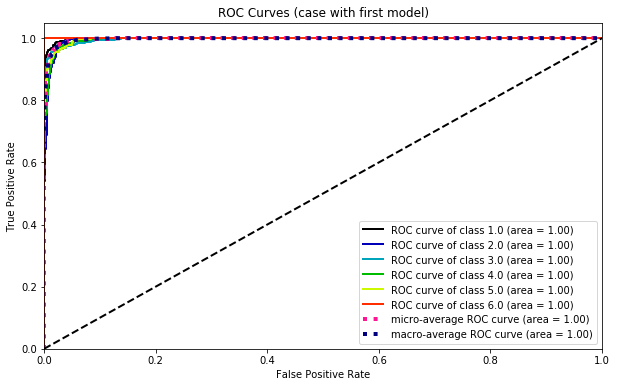

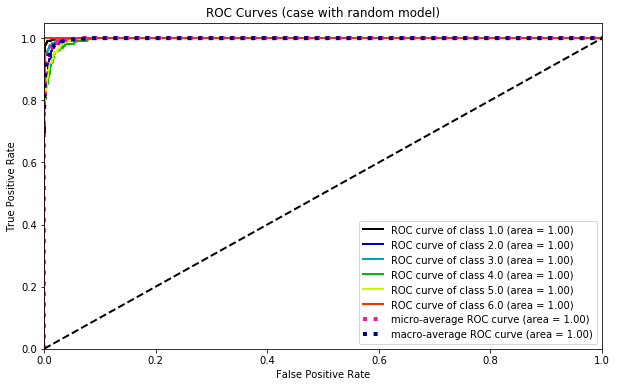

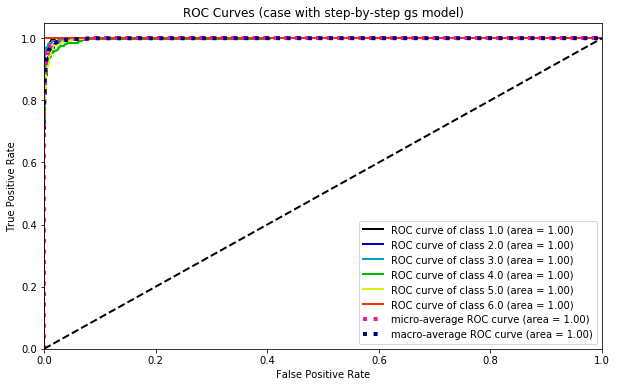

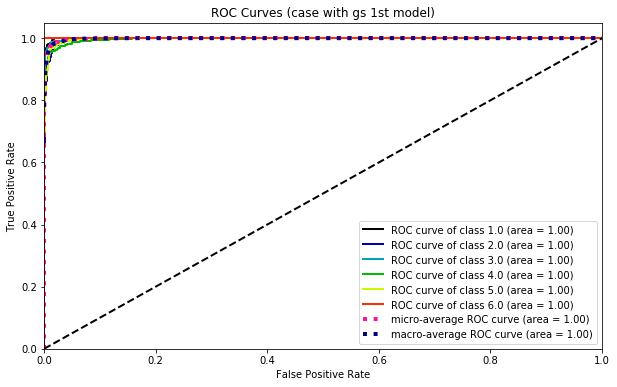

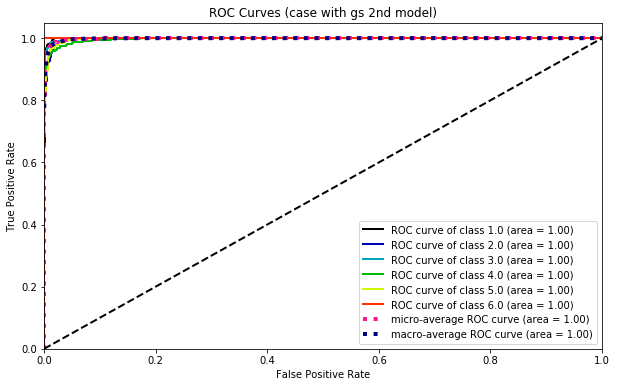

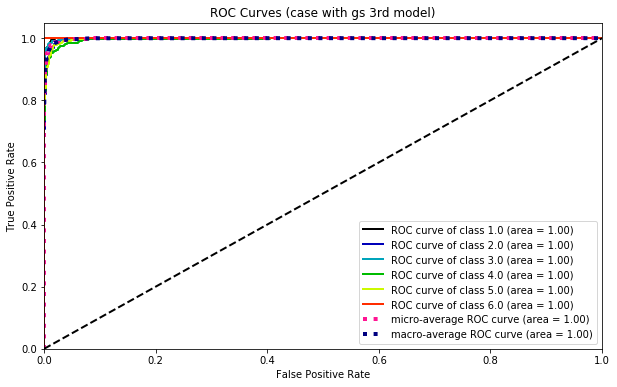

In [352]:
scikitplot.metrics.plot_roc(
    y_test,
    first_model.predict_proba(X_test_unique), 
    figsize=(10, 6), 
    title="ROC Curves (case with {})".format("first model"),
)

scikitplot.metrics.plot_roc(
    y_test,
    random_model.predict_proba(X_test_unique), 
    figsize=(10, 6), 
    title="ROC Curves (case with {})".format("random model"),
)

scikitplot.metrics.plot_roc(
    y_test,
    gs_model.predict_proba(X_test_unique), 
    figsize=(10, 6), 
    title="ROC Curves (case with {})".format("step-by-step gs model"),
)

scikitplot.metrics.plot_roc(
    y_test,
    gs_1st_best.predict_proba(X_test_unique), 
    figsize=(10, 6), 
    title="ROC Curves (case with {})".format("gs 1st model"),
)

scikitplot.metrics.plot_roc(
    y_test,
    gs_2nd_best.predict_proba(X_test_unique), 
    figsize=(10, 6), 
    title="ROC Curves (case with {})".format("gs 2nd model"),
)

scikitplot.metrics.plot_roc(
    y_test,
    gs_3rd_best.predict_proba(X_test_unique), 
    figsize=(10, 6), 
    title="ROC Curves (case with {})".format("gs 3rd model"),
)

Из ROC-AUC графиков можно сделать вывод, что все модели хорошие.

In [354]:
print(
    "first model: accuracy = ",
    accuracy_score(y_true=y_test, y_pred=first_model.predict(X_test_unique))
)

print(
    "random_model: accuracy = ",
    accuracy_score(y_true=y_test, y_pred=random_model.predict(X_test_unique))
)

print(
    "gs_model: accuracy = ",
    accuracy_score(y_true=y_test, y_pred=gs_model.predict(X_test_unique))
)

print(
    "gs_1st_best: accuracy = ",
    accuracy_score(y_true=y_test, y_pred=gs_1st_best.predict(X_test_unique))
)

print(
    "gs_2nd_best: accuracy = ",
    accuracy_score(y_true=y_test, y_pred=gs_2nd_best.predict(X_test_unique))
)

print(
    "gs_3rd_best: accuracy = ",
    accuracy_score(y_true=y_test, y_pred=gs_3rd_best.predict(X_test_unique))
)

first model: accuracy =  0.9440108585001696
random_model: accuracy =  0.9504580929759077
gs_model: accuracy =  0.9630132337970818
gs_1st_best: accuracy =  0.9616559212758737
gs_2nd_best: accuracy =  0.9619952494061758
gs_3rd_best: accuracy =  0.9630132337970818


Таким образом, три самые лучшие модели -- это:
* step-by-step gs model
* gs_3rd_model
* gs_2nd_model

Заметим, что даже модель с по отдельности подобранными примерно параметрами дает хороший результат. Также все три модели, подобранные в одном grid search примерно одинаковы. Модель с параметрами, подобранными random search, дает результаты лучше, чем самая первая примерная модель, но хуже, чем подробный grid search (логично, так как в random search просматриваются не все точки, а только случайно выбиранные). Лучше всего модель, подобранная по шагам с помощью grid search, в том числе потому что рассмотрено больше параметров.

### Part 2. Blending the models

Take three (or more) best models and try to build the blending ensemble of them. Compare the quality of the final model using the same quality measures as above.

Возьмем три самые лучшие модели из предыдущего пункта.

In [358]:
best_models = [
    LGBMClassifier(
        n_estimators=450,
        max_depth=3,
        min_data_in_leaf=1,
        learning_rate=0.5,
        bagging_fraction=0.5,
        feature_fraction=0.2,
        bagging_freq=1),
    LGBMClassifier(
        n_estimators=300,
        max_depth=3,
        min_data_in_leaf=4,
        bagging_fraction=0.5,
        feature_fraction=0.2,
        bagging_freq=1,
        learning_rate=0.5),
    LGBMClassifier(
        n_estimators=450,
        max_depth=3,
        min_data_in_leaf=1,
        bagging_fraction=0.5,
        feature_fraction=0.2,
        bagging_freq=1,
        learning_rate=0.5)
]

In [220]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from copy import deepcopy

Реализуем свой класс `BlendingEnsembleClassifier`. Внутри него такой дизайн: в `base_models` лежит лист базовых моделей, в `choose_percentage` -- сколько от всей входной выборки в методе `fit` нужно отдать под выборку, на которой подбираются коеффициенты.

В методе `fit` выборка делится на две части: на одной обучаем базовые модели, на другой с помощью `LinearRegression` подбираем коэффициенты.

В методе `predict` базовые модели дают свои результаты, которые учитываются в ответе с коэффициентами, полученными в методе `fit`. Ответ округляется до ближайшего целого, так как конкретно этот класс решает задачу классификации.

In [359]:
class BlendingEnsembleClassifier(BaseEstimator):
    def __init__(self, base_models, choose_percentage=0.2):
        self.base_models = deepcopy(base_models)
        self.choose_percentage = choose_percentage
    
    def fit(self, X, y):
        self.base_models_ = [deepcopy(x) for x in self.base_models]
        
        X_train, X_choose, y_train, y_choose = train_test_split(X, y, test_size=self.choose_percentage)
        
        choose_predictions = np.zeros((X_choose.shape[0], len(self.base_models)))
        
        for i, model in tqdm_notebook(enumerate(self.base_models_)):
            model.fit(X_train, y_train)
            y_pred = model.predict(X_choose)
            choose_predictions[:, i] = y_pred
            
        self.linreg_model = LinearRegression()
        self.linreg_model.fit(choose_predictions, y_choose)
            
    def predict(self, X):
        meta_features = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.base_models_):
            y_pred = model.predict(X)
            meta_features[:, i] = y_pred

        return [round(elem) for elem in self.linreg_model.predict(meta_features)]

In [364]:
blend_ens = BlendingEnsembleClassifier(best_models)
blend_ens.fit(X_train_unique, y_train)

In [365]:
accuracy_score(y_true=y_test, y_pred=blend_ens.predict(X_test_unique))

0.9609772650152698

In [362]:
from vecstack import stacking

In [368]:
stacked_train, stacked_test = stacking(
    best_models, X_train_unique, y_train, X_test_unique,
    regression=False, mode='oof_pred_bag', needs_proba=False,
    save_dir=None, metric=accuracy_score, n_folds=5,
    stratified=True, shuffle=True, random_state=0
)

In [369]:
model = LGBMClassifier()
model.fit(stacked_train, y_train)
accuracy_score(y_pred=model.predict(stacked_test), y_true=y_test)

0.9562266711910418

Видно, что самописный `BlendingEnsembleClassifier` даёт хороший результат, хоть немного и уменьшает точность. Вполне закономерный результат, так как мы усредняем все модели между собой.

Библиотечный `stacking` дает результат хуже, чем даже `BlendingEnsembleClassifier`. Ну, бывает.

### Part 3. Explaining the model and estimating the feature importances.

Now your goal to take three best models and estimate feature importances using this models.

* First, use the methods that libraries provide by default (e.g. `lightgbm.plot_importance`).
* Next, use the [`shap`](https://github.com/slundberg/shap) library to explain the models behaviour and analyse the model performance. Compare the feature importances estimated by `shap` and by methods on the previous step.

In [265]:
from lightgbm import plot_importance
import shap

### Step-by-step gs model

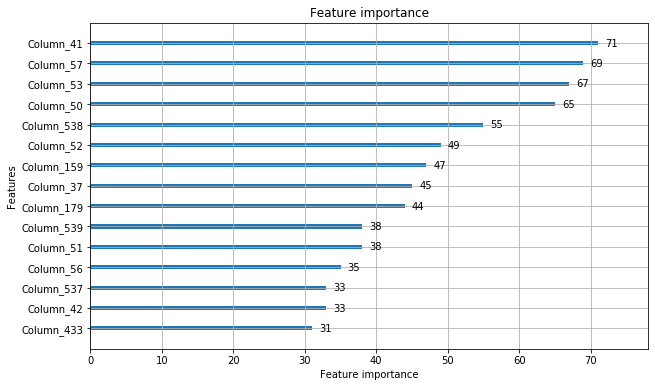

In [375]:
plot_importance(gs_model, max_num_features=15, figsize=(10, 6))

In [389]:
shap.initjs()
gs_model_expl = shap.TreeExplainer(gs_model)
gs_model_shap_values = gs_model_expl.shap_values(X_train_unique)

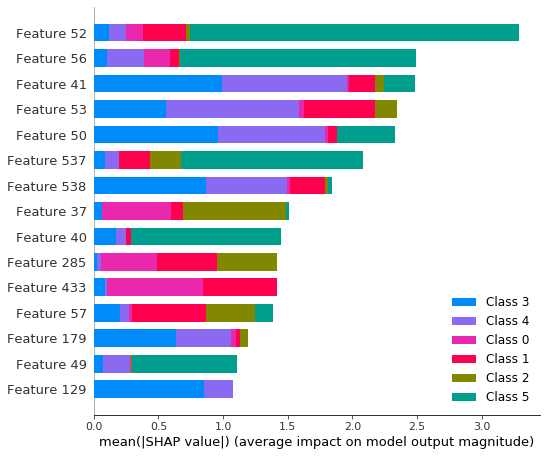

In [390]:
shap.summary_plot(gs_model_shap_values, max_display=15)

Заметим, что списки фичей, отсортированные по важности, у `lightgbm.plot_importance` и `shap` не совпадают точь в точь, но в целом их топы одинаковы в целом.

Расммотрим три самые важные фичи в `shap` (см. график).

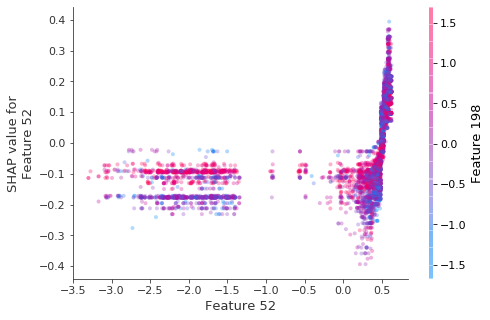

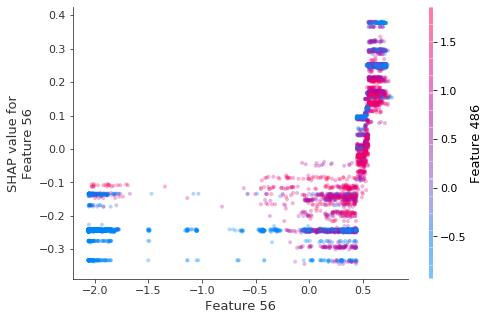

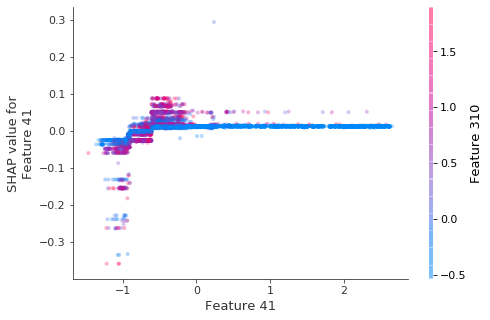

In [391]:
shap.dependence_plot("Feature 52", gs_model_shap_values[0], X_train_unique, alpha=0.3)
shap.dependence_plot("Feature 56", gs_model_shap_values[0], X_train_unique, alpha=0.3)
shap.dependence_plot("Feature 41", gs_model_shap_values[0], X_train_unique, alpha=0.3)

Из последнего графика видно, что влияние фичи $41$ на модель практически не зависит от других фичей. 

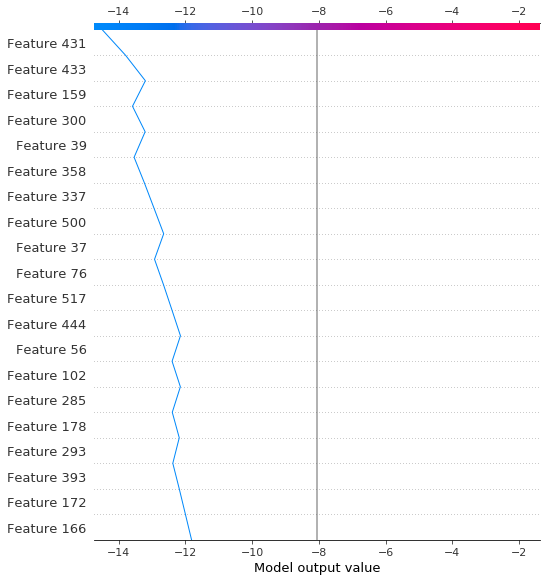

In [393]:
shap.decision_plot(
    base_value=gs_model_expl.expected_value[0],
    shap_values=gs_model_shap_values[0][0]
)

Из `decision_plot` можно видеть, что модель на $class0$ на первом сэмпле сходится к ответу медленно.

### gs_2nd_best model
Проделаем те же самые операции для второ лучшей модели.

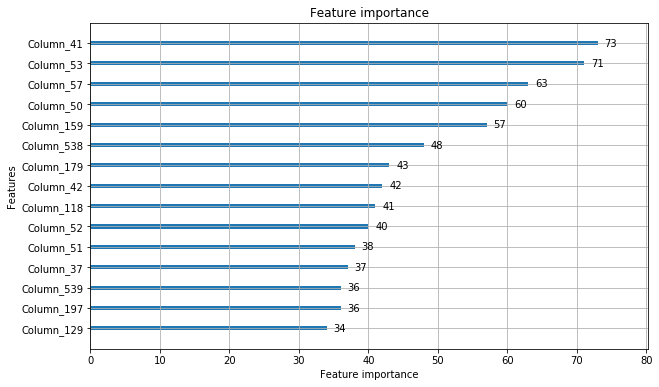

In [394]:
plot_importance(gs_2nd_best, max_num_features=15, figsize=(10, 6))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


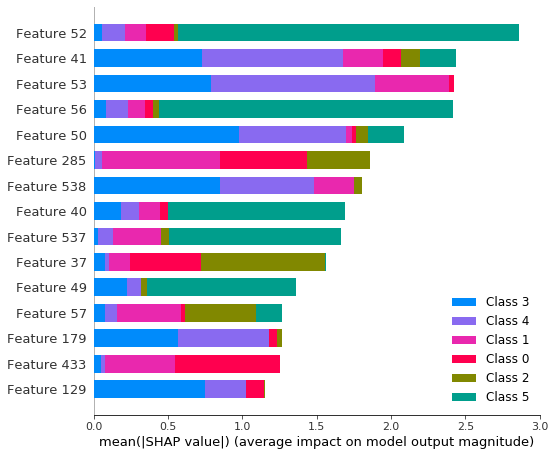

In [395]:
shap.initjs()
gs_2nd_model_expl = shap.TreeExplainer(gs_2nd_best)
gs_2nd_model_shap_values = gs_2nd_model_expl.shap_values(X_train_unique)
shap.summary_plot(gs_2nd_model_shap_values, max_display=15)

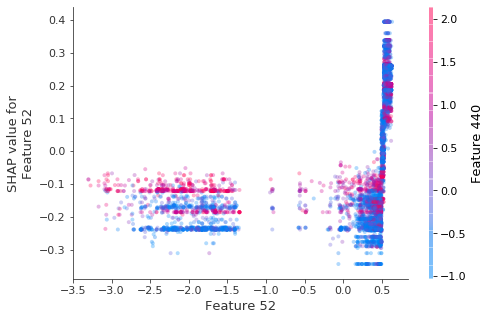

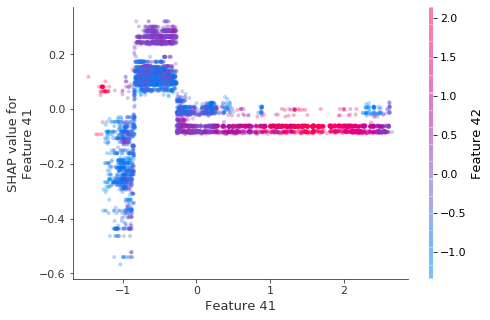

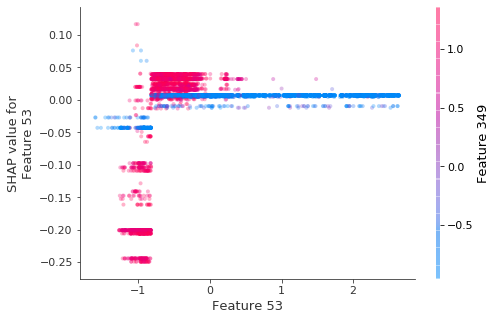

In [397]:
shap.dependence_plot("Feature 52", gs_2nd_model_shap_values[0], X_train_unique, alpha=0.3)
shap.dependence_plot("Feature 41", gs_2nd_model_shap_values[0], X_train_unique, alpha=0.3)
shap.dependence_plot("Feature 53", gs_2nd_model_shap_values[0], X_train_unique, alpha=0.3)

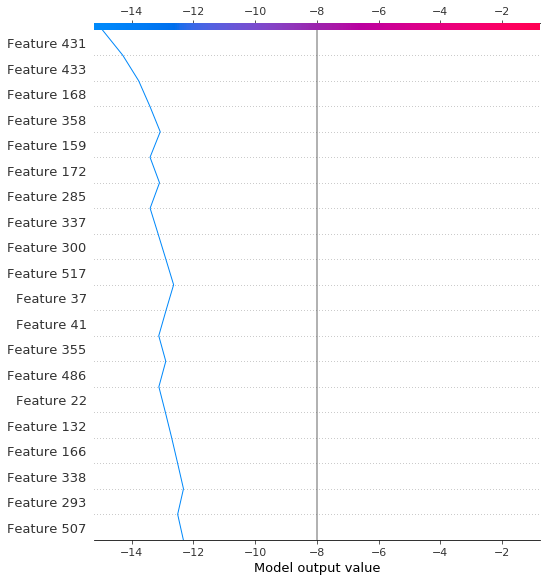

In [398]:
shap.decision_plot(
    base_value=gs_2nd_model_expl.expected_value[0],
    shap_values=gs_2nd_model_shap_values[0][0]
)

По этой модели в целом можно сделать такие же выводы, как и для предыдущей.

### gs_3rd_model
Исследуем третью модель так же, как две предыдущие.

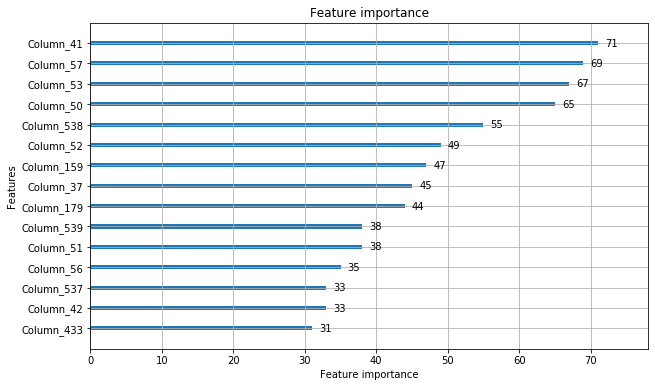

In [399]:
plot_importance(gs_3rd_best, max_num_features=15, figsize=(10, 6))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


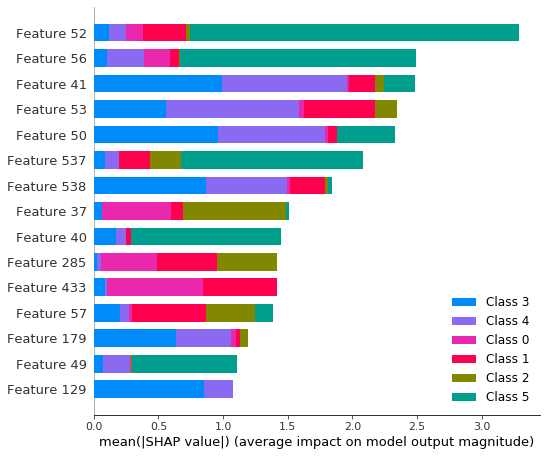

In [400]:
shap.initjs()
gs_3rd_model_expl = shap.TreeExplainer(gs_3rd_best)
gs_3rd_model_shap_values = gs_3rd_model_expl.shap_values(X_train_unique)
shap.summary_plot(gs_3rd_model_shap_values, max_display=15)

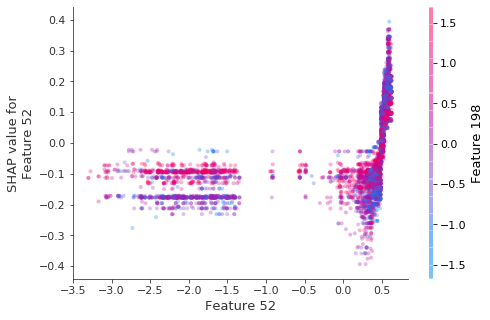

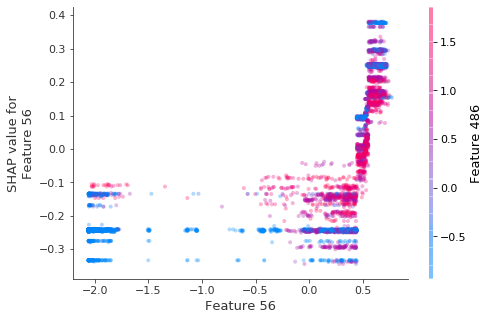

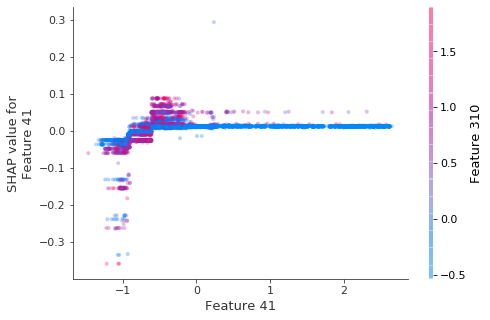

In [403]:
shap.dependence_plot("Feature 52", gs_3rd_model_shap_values[0], X_train_unique, alpha=0.3)
shap.dependence_plot("Feature 56", gs_3rd_model_shap_values[0], X_train_unique, alpha=0.3)
shap.dependence_plot("Feature 41", gs_3rd_model_shap_values[0], X_train_unique, alpha=0.3)

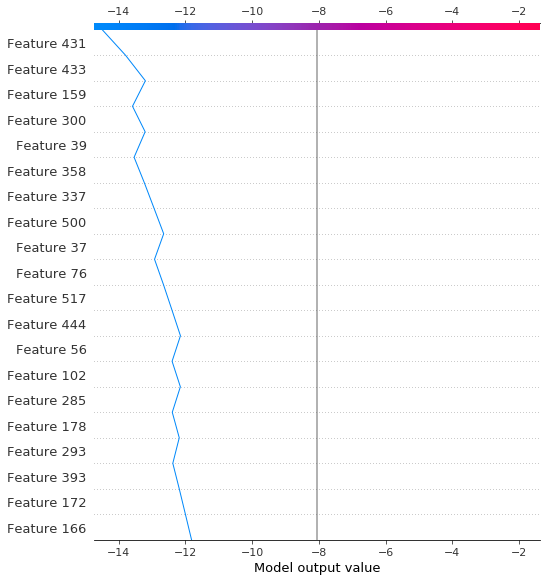

In [402]:
shap.decision_plot(
    base_value=gs_3rd_model_expl.expected_value[0],
    shap_values=gs_3rd_model_shap_values[0][0]
)

Соответственно, для этой модели результаты схожи с предыдущей.

### Вывод по 3му пункту
Если у всех трех моделей сравним графики, построенные `lightgbm.plot_importance`, то увидим, что для них наиболее важны одни и те же фичи. Если у всех трех моделей сравним графики `shap`, то увидим то же самое.